# Notebook 02: Deep EDA and Feature Engineering

---

## Executive Summary

This notebook performs **in-depth Exploratory Data Analysis (EDA)** and **Feature Engineering** on the Nashville traffic stop dataset.

**Input:** `artifacts/cleaned_full.parquet` from Notebook 01 (3.09M rows)  
**Target:** `arrest_made` (binary, 1.62% positive rate)

**Lecture Concepts Applied:**
- **Encoding:** One-Hot, Frequency, Binary, Target (OOF + Smoothing)
- **Scaling:** StandardScaler, RobustScaler, Power Transform
- **Bias Detection:** Historical, Sampling, Label, Measurement bias

---


## Table of Contents

- PART A: EDA
- PART B: Feature Engineering


# ═══════════════════════════════════════════════════════════════
# PART A: EXPLORATORY DATA ANALYSIS (EDA)
# ═══════════════════════════════════════════════════════════════


## A.1 Reproducibility & Data Loading

**WHY:** Consistent environment ensures reproducible results.


In [1]:
# === REPRODUCIBILITY HEADER ===
import os, random, warnings, re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, kurtosis
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ['PYTHONHASHSEED'] = str(SEED)
warnings.filterwarnings('ignore')

print("=" * 60)
print("NOTEBOOK 02 - REPRODUCIBILITY HEADER")
print("=" * 60)
print(f"Timestamp: {datetime.now().isoformat()}")
print(f"SEED: {SEED}")
import sklearn; print(f"Pandas: {pd.__version__} | NumPy: {np.__version__} | Sklearn: {sklearn.__version__}")


NOTEBOOK 02 - REPRODUCIBILITY HEADER
Timestamp: 2026-01-16T16:02:44.699224
SEED: 42
Pandas: 2.3.3 | NumPy: 2.2.6 | Sklearn: 1.7.2


In [2]:
# === LOAD DATA ===
print("Loading cleaned_full.parquet...")
df = pd.read_parquet('artifacts/cleaned_full.parquet')
print(f"Loaded {len(df):,} rows, {len(df.columns)} columns")

# Prepare train/test split
df = df.dropna(subset=['arrest_made']).copy()
df['arrest_made'] = df['arrest_made'].astype(int)

train_idx, test_idx = train_test_split(df.index, test_size=0.2, stratify=df['arrest_made'], random_state=SEED)
df_train = df.loc[train_idx].copy().reset_index(drop=True)
df_test = df.loc[test_idx].copy().reset_index(drop=True)

print(f"Train: {len(df_train):,} | Test: {len(df_test):,}")
print(f"Arrest rate - Train: {df_train['arrest_made'].mean()*100:.2f}% | Test: {df_test['arrest_made'].mean()*100:.2f}%")

# Create race_canonical column immediately (used throughout notebook)
race_map = {'white': 'White', 'black': 'Black', 'hispanic': 'Hispanic', 
            'asian/pacific islander': 'Asian', 'other': 'Other', 'unknown': 'Unknown'}
df_train['race_canonical'] = df_train['subject_race'].astype(str).str.lower().map(race_map).fillna('Other')
df_test['race_canonical'] = df_test['subject_race'].astype(str).str.lower().map(race_map).fillna('Other')
print(f"Race groups: {df_train['race_canonical'].unique().tolist()}")


Loading cleaned_full.parquet...
Loaded 3,092,351 rows, 42 columns
Train: 2,473,858 | Test: 618,465
Arrest rate - Train: 1.62% | Test: 1.62%
Race groups: ['Black', 'White', 'Hispanic', 'Asian', 'Other', 'Unknown']


## A.1.1 Notebook 01 Preprocessing Summary

Acknowledge prior data cleaning work to avoid redundant analysis.

The following data quality checks were **already completed in Notebook 01** and saved to `cleaned_full.parquet`:

| Check | Result | Action Taken |
|-------|--------|--------------|
| **Missing Values** | 28 missing in `arrest_made` | Dropped rows |
| **Duplicates** | 0 found | None needed |
| **Age Outliers** | Range 10-99 | Kept as valid (biologically plausible) |
| **Contraband Logic** | 100% valid when search=True | Verified structural missingness |
| **Geographic Bounds** | 6% outside Nashville | Flagged but kept |
| **Precinct-Zone Correlation** | r=1.00 | Use only `precinct` for modeling |

**Baseline Model (Notebook 01):**
- Features: `subject_age`, `subject_race`, `subject_sex`, `type`, `search_conducted`, `frisk_performed`
- ROC-AUC: **0.9055**
- F1: **0.4324**
- **Goal:** Improve on baseline with engineered features

---


In [3]:
# === VERIFY DATA FROM NOTEBOOK 01 ===
print("=" * 60)
print("NOTEBOOK 01 PREPROCESSING VERIFICATION")
print("=" * 60)
print(f"Data source: artifacts/cleaned_full.parquet")
print(f"Rows: {len(df_train) + len(df_test):,} (after train/test split)")
print(f"Target (arrest_made) missing: {df_train['arrest_made'].isna().sum() + df_test['arrest_made'].isna().sum()}")
print()
print("Notebook 01 Baseline Performance:")
print("  ROC-AUC: 0.9055")
print("  F1: 0.4324")
print("  Features: 6 basic features")
print()
print("This notebook will engineer additional features to improve on baseline.")


NOTEBOOK 01 PREPROCESSING VERIFICATION
Data source: artifacts/cleaned_full.parquet
Rows: 3,092,323 (after train/test split)
Target (arrest_made) missing: 0

Notebook 01 Baseline Performance:
  ROC-AUC: 0.9055
  F1: 0.4324
  Features: 6 basic features

This notebook will engineer additional features to improve on baseline.


## A.2 Univariate Analysis

Understand individual feature distributions before combining them.


### A.2.1 Target Variable: Class Imbalance

Extreme imbalance affects model training and metric selection.


TARGET VARIABLE: arrest_made
arrest_made
0    2433693
1      40165
Name: count, dtype: int64

Arrest rate: 1.62%
Class imbalance ratio: 60.6:1


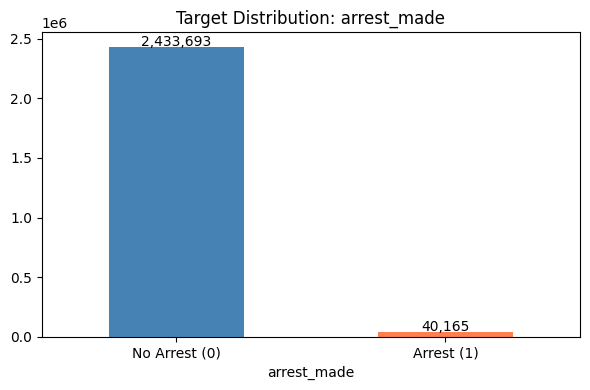

In [4]:
# === TARGET DISTRIBUTION ===
print("TARGET VARIABLE: arrest_made")
print("=" * 50)
target_counts = df_train['arrest_made'].value_counts()
print(target_counts)
print(f"\nArrest rate: {df_train['arrest_made'].mean()*100:.2f}%")
print(f"Class imbalance ratio: {target_counts[0]/target_counts[1]:.1f}:1")

# Visualization
fig, ax = plt.subplots(figsize=(6, 4))
target_counts.plot(kind='bar', color=['steelblue', 'coral'], ax=ax)
ax.set_title('Target Distribution: arrest_made')
ax.set_xticklabels(['No Arrest (0)', 'Arrest (1)'], rotation=0)
for i, v in enumerate(target_counts):
    ax.text(i, v + 5000, f'{v:,}', ha='center')
plt.tight_layout()
plt.show()


#### INTERPRETATION: 60:1 class imbalance requires:
- class_weight='balanced' or SMOTE"
- Focus on F1/ROC-AUC, not accuracy"

### A.2.2 Numeric Features: Distribution & Skewness

Skewed features may need power transformation for linear models.


In [5]:
# === SKEWNESS ANALYSIS ===
print("SKEWNESS ANALYSIS")
print("=" * 60)

# Define feature
col = 'subject_age'
data = df_train[col].dropna()

# Calculate metrics
sk = skew(data)
kurt = kurtosis(data)

# Create DataFrame
skew_df = pd.DataFrame([{
    'Feature': col, 
    'Skewness': round(sk, 3), 
    'Kurtosis': round(kurt, 3), 
}])

display(skew_df)

SKEWNESS ANALYSIS


,Feature,Skewness,Kurtosis
0,subject_age,0.765,0.013


OUTLIER DETECTION: subject_age
Age Statistics: Min=10, Max=99, Mean=37.1, Median=34.0

Method Comparison:
  Z-score (|z| > 3): 13,925 outliers
  IQR method: 16,278 outliers (fences: -6 to 78)


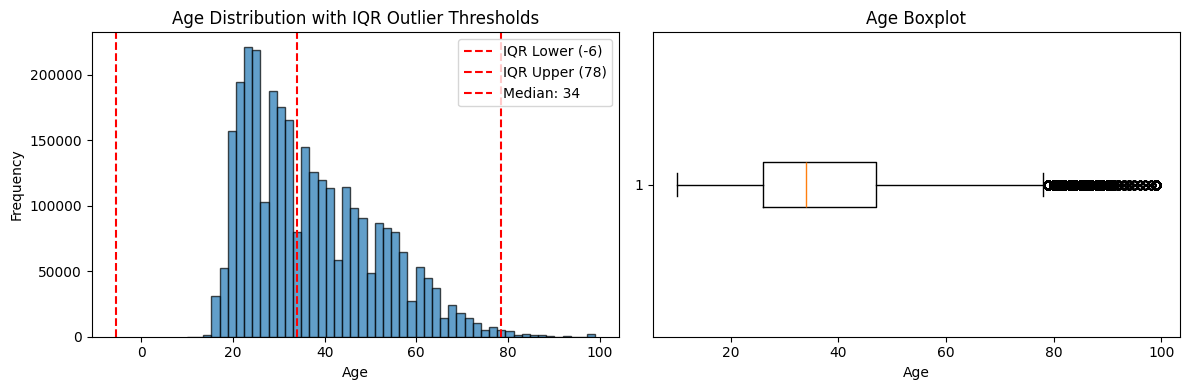

In [6]:
# Outlier Detection: Subject Age
print("OUTLIER DETECTION: subject_age")
print("=" * 60)

age_data = df['subject_age'].dropna()

# Method 1: Z-score
z_scores = np.abs(stats.zscore(age_data))
z_outliers = (z_scores > 3).sum()

# Method 2: IQR
Q1, Q3 = age_data.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR
iqr_outliers = ((age_data < lower_fence) | (age_data > upper_fence)).sum()

print(f"Age Statistics: Min={age_data.min()}, Max={age_data.max()}, Mean={age_data.mean():.1f}, Median={age_data.median():.1f}")
print(f"\nMethod Comparison:")
print(f"  Z-score (|z| > 3): {z_outliers:,} outliers")
print(f"  IQR method: {iqr_outliers:,} outliers (fences: {lower_fence:.0f} to {upper_fence:.0f})")

# Visualize age distribution with outlier thresholds
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(age_data, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(lower_fence, color='red', linestyle='--', label=f'IQR Lower ({lower_fence:.0f})')
axes[0].axvline(upper_fence, color='red', linestyle='--', label=f'IQR Upper ({upper_fence:.0f})')
axes[0].axvline(age_data.median(), color='red', linestyle='--', label=f'Median: {age_data.median():.0f}')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Age Distribution with IQR Outlier Thresholds')
axes[0].legend()

# Boxplot
axes[1].boxplot(age_data, vert=False)
axes[1].set_xlabel('Age')
axes[1].set_title('Age Boxplot')

plt.tight_layout()
plt.show()

#### INTERPRETATION: Outlier Detection

**Observation:**
- **Skewed Distribution**: The histogram and boxplot confirm `subject_age` follows a right-skewed distribution (mean=37.1 > median=34).
- **Statistical Threshold Issues**: IQR lower fence is -6 (impossible for age), upper fence is 78. Standard 1.5×IQR rule can be overly sensitive for skewed data.
- **Biological Plausibility**: Maximum value of 99 is within realistic human limits.

**Decision:**
- **Retention**: Keep all records. Values 10-99 represent legitimate, rare data points, not errors.
- **Modeling Strategy**: Baseline uses Logistic Regression (linear); Decision Tree is explored in Notebook 03 for handling non-linear patterns and skew.

### A.2.3 Categorical Features: Cardinality Analysis

Cardinality determines encoding method.


In [7]:
# === CARDINALITY ANALYSIS ===
print("CARDINALITY ANALYSIS")
print("=" * 50)

cat_cols = ['subject_race', 'subject_sex', 'type', 'violation', 'vehicle_registration_state', 'officer_id_hash']
valid_cats = [c for c in cat_cols if c in df_train.columns]

cardinality = []
for col in valid_cats:
    nunique = df_train[col].nunique()
    cardinality.append({'Feature': col, 'Unique': nunique})

card_df = pd.DataFrame(cardinality).sort_values('Unique')
print(card_df.to_string(index=False))


CARDINALITY ANALYSIS
                   Feature  Unique
                      type       1
               subject_sex       2
              subject_race       6
                 violation       8
vehicle_registration_state      51
           officer_id_hash    2247


#### INTREPRETATION: Cardinality Analysis
ENCODING DECISIONS:
   - subject_sex (2): One-Hot Encoding
   - type (1-2): One-Hot Encoding
   - subject_race (6): One-Hot or Frequency Encoding
   - vehicle_registration_state (~50): Binary Encoding
   - officer_id_hash (1000+): Target Encoding with OOF + Smoothing

## A.3 Bivariate Analysis

Understand relationships between features and target.


### A.3.1 Arrest Rate by Demographics


ARREST RATE BY RACE
                        Arrest_Rate  Total_Stops  Arrests
subject_race                                             
hispanic                       3.11       131877     4097
black                          2.26       932722    21061
white                          1.09      1336562    14520
other                          0.86         8326       72
asian/pacific islander         0.70        33379      234
unknown                        0.54        29534      160


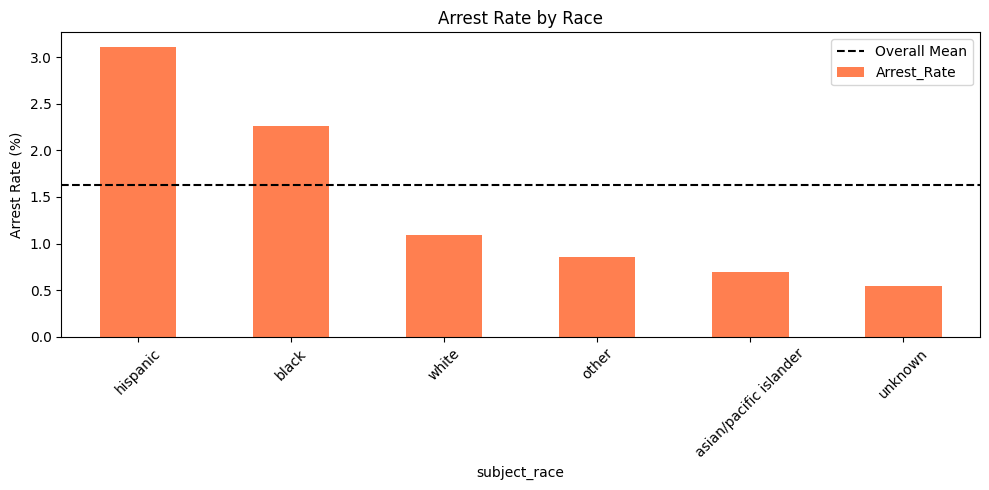


** INTERPRETATION:
   - hispanic: 3.11% arrest rate
   - black: 2.26% arrest rate
   - white: 1.09% arrest rate
   - Disparity suggests potential HISTORICAL BIAS in data


In [8]:
# === ARREST RATE BY RACE ===
print("ARREST RATE BY RACE")
print("=" * 50)

race_stats = df_train.groupby('subject_race')['arrest_made'].agg(['mean', 'count', 'sum'])
race_stats.columns = ['Arrest_Rate', 'Total_Stops', 'Arrests']
race_stats['Arrest_Rate'] = (race_stats['Arrest_Rate'] * 100).round(2)
race_stats = race_stats.sort_values('Arrest_Rate', ascending=False)
print(race_stats)

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
race_stats['Arrest_Rate'].plot(kind='bar', color='coral', ax=ax)
ax.axhline(df_train['arrest_made'].mean()*100, color='black', linestyle='--', label='Overall Mean')
ax.set_ylabel('Arrest Rate (%)')
ax.set_title('Arrest Rate by Race')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Dynamic interpretation based on actual computed values
top_races = race_stats.head(3)
print("\n** INTERPRETATION:")
for i, (race, row) in enumerate(top_races.iterrows()):
    print(f"   - {race}: {row['Arrest_Rate']:.2f}% arrest rate")
print("   - Disparity suggests potential HISTORICAL BIAS in data")


### A.3.2 Temporal Patterns


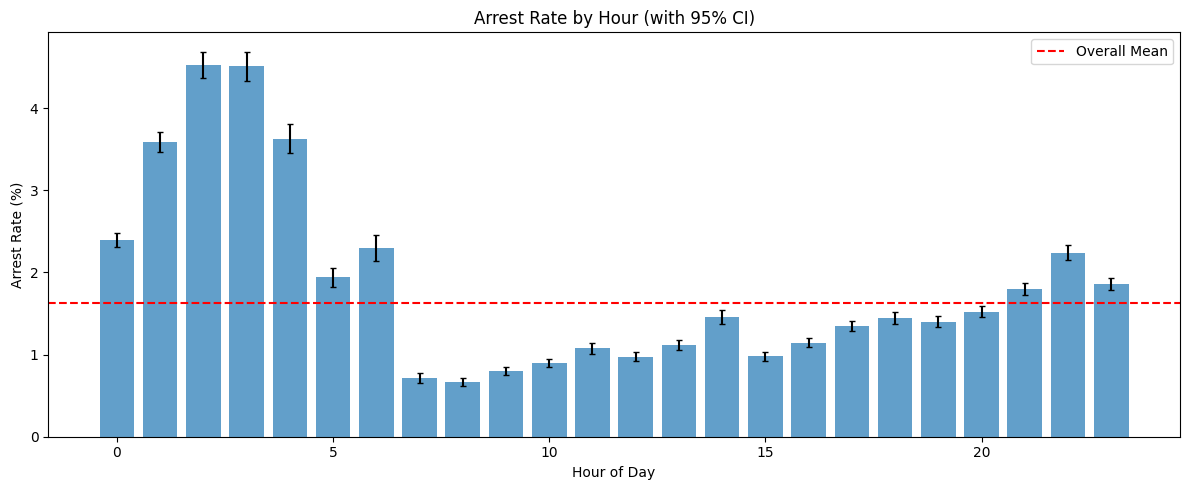

In [9]:
# === TEMPORAL FEATURE EXTRACTION ===
def extract_temporal(data):
    df_temp = data.copy()
    df_temp['date_parsed'] = pd.to_datetime(df_temp['date'], errors='coerce')
    df_temp['year'] = df_temp['date_parsed'].dt.year
    df_temp['month'] = df_temp['date_parsed'].dt.month
    df_temp['day_of_week'] = df_temp['date_parsed'].dt.dayofweek
    df_temp['hour'] = pd.to_datetime(df_temp['time'], format='%H:%M:%S', errors='coerce').dt.hour
    df_temp['sin_hour'] = np.sin(2 * np.pi * df_temp['hour'] / 24)
    df_temp['cos_hour'] = np.cos(2 * np.pi * df_temp['hour'] / 24)
    df_temp['is_night'] = df_temp['hour'].apply(lambda h: 1 if pd.notna(h) and (h >= 20 or h <= 5) else 0)
    return df_temp

df_train = extract_temporal(df_train)
df_test = extract_temporal(df_test)

# Arrest rate by hour
hourly = df_train.groupby('hour')['arrest_made'].agg(['mean', 'count'])
hourly['se'] = np.sqrt(hourly['mean'] * (1 - hourly['mean']) / hourly['count'])

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(hourly.index, hourly['mean']*100, yerr=1.96*hourly['se']*100, capsize=2, alpha=0.7)
ax.axhline(df_train['arrest_made'].mean()*100, color='red', linestyle='--', label='Overall Mean')
ax.set_xlabel('Hour of Day'); ax.set_ylabel('Arrest Rate (%)')
ax.set_title('Arrest Rate by Hour (with 95% CI)')
ax.legend()
plt.tight_layout()
plt.show()

#### INTERPRETATION: Temporal Analysis (Arrest Rate by Hour)

- **Significant Nighttime Spike:** Arrest probability drastically increases during late-night hours (00:00–04:00), peaking above **4.5%**—more than double the overall mean (~1.6%).
- **Daytime Lull:** Conversely, arrest rates drop to their lowest (<1.0%) during morning commute and business hours (07:00–16:00).
- **Statistical Confidence:** The tight non-overlapping 95% confidence intervals confirm that these temporal differences are statistically significant, not random noise.

**Actionable Insight:**
* **Feature Engineering:** Time is a non-linear predictor. We should create a new categorical feature (e.g., `is_night`) to capture this high-risk window for the model.

### A.3.3 Correlation Analysis


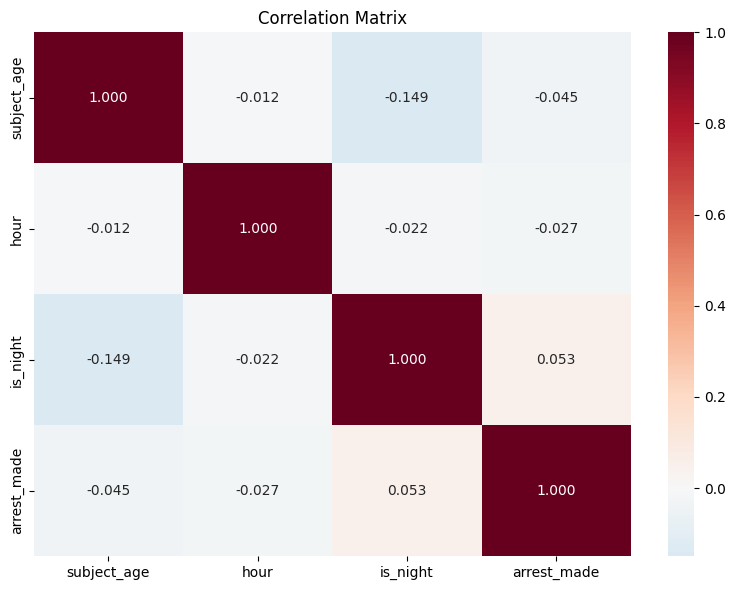

In [10]:
# === CORRELATION HEATMAP ===
# Select numeric columns for correlation
corr_cols = ['subject_age', 'hour', 'is_night', 'arrest_made']
valid_corr = [c for c in corr_cols if c in df_train.columns]

corr_matrix = df_train[valid_corr].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.3f', ax=ax)
ax.set_title('Correlation Matrix')
plt.tight_layout()
plt.show()


#### INTERPRETATION: Correlation Analysis
- is_night ↔ arrest_made (r=0.053): Weak positive correlation confirms night hours have slightly higher arrest rates")
- subject_age ↔ is_night (r=-0.149): Night stops involve younger subjects on average")
- All correlations |r| < 0.2: No strong multicollinearity; features are sufficiently independent")

## A.4 Bias Detection & Statistical Tests

Detecting bias, outliers, and analytical fallacies (Simpson's Paradox).


### A.4.1 Historical Bias Check

Data reflects past inequalities that may perpetuate discrimination.


In [11]:
# === HISTORICAL BIAS: Race Disparities ===
print("HISTORICAL BIAS CHECK")
print("=" * 50)

# Statistical test: Chi-square for independence
contingency = pd.crosstab(df_train['subject_race'], df_train['arrest_made'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-square test for Race vs Arrest independence:")
print(f"  Chi2 statistic: {chi2:.2f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Degrees of freedom: {dof}")

if p_value < 0.05:
    print("\n  RESULT: Reject H0 - Race and Arrest are NOT independent")
    print("  This suggests HISTORICAL BIAS in the data")
else:
    print("\n  RESULT: Cannot reject H0 - No significant association")


HISTORICAL BIAS CHECK
Chi-square test for Race vs Arrest independence:
  Chi2 statistic: 7005.45
  P-value: 0.00e+00
  Degrees of freedom: 5

  RESULT: Reject H0 - Race and Arrest are NOT independent
  This suggests HISTORICAL BIAS in the data


### A.4.1.1 Effect Size Analysis (Cramer's V)

- P-values only tell us if an effect exists, not how LARGE the effect is. With large samples (3M+ rows), 
even tiny effects are statistically significant. Effect size provides practical significance.
- Statistical rigor requires both significance AND effect size.

In [12]:
# === EFFECT SIZE: Cramer's V ===
print("EFFECT SIZE ANALYSIS (Cramer's V)")
print("=" * 50)

def calculate_cramers_v(contingency_table, chi2_stat):
    '''
    Calculate Cramer's V for effect size interpretation.
    
    Cramer's V = sqrt(chi2 / (n * min(r-1, c-1)))
    
    Interpretation (Cohen, 1988):
    - 0.1 = Small effect
    - 0.3 = Medium effect  
    - 0.5 = Large effect
    '''
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    if min_dim == 0:
        return 0
    return np.sqrt(chi2_stat / (n * min_dim))

# Use the contingency table from previous cell (race vs arrest)
# Use same column as Chi-square test (Cell A.4.1) for consistency
contingency = pd.crosstab(df_train['subject_race'], df_train['arrest_made'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)

cramers_v = calculate_cramers_v(contingency, chi2)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.2e}")
print(f"Cramer's V (effect size): {cramers_v:.4f}")
print()

# Interpretation
if cramers_v < 0.1:
    effect_interpretation = "SMALL (< 0.1) - minimal practical significance"
elif cramers_v < 0.3:
    effect_interpretation = "SMALL-MEDIUM (0.1-0.3) - modest effect"
elif cramers_v < 0.5:
    effect_interpretation = "MEDIUM (0.3-0.5) - moderate effect"
else:
    effect_interpretation = "LARGE (> 0.5) - substantial effect"

print(f"** Effect Size Interpretation (Cohen's Guidelines):")
print(f"   0.1 = Small, 0.3 = Medium, 0.5 = Large")
print(f"   Result: {effect_interpretation}")
print()
print("** KEY INSIGHT:")
print("   While p-value shows statistical significance (due to large n),")
print("   the effect size tells us the PRACTICAL magnitude of the race-arrest association.")

EFFECT SIZE ANALYSIS (Cramer's V)
Chi-square statistic: 7005.45
P-value: 0.00e+00
Cramer's V (effect size): 0.0532

** Effect Size Interpretation (Cohen's Guidelines):
   0.1 = Small, 0.3 = Medium, 0.5 = Large
   Result: SMALL (< 0.1) - minimal practical significance

** KEY INSIGHT:
   While p-value shows statistical significance (due to large n),
   the effect size tells us the PRACTICAL magnitude of the race-arrest association.


#### INTERPRETATION: Historical Bias Check (Race vs. Arrest) & Effect Size Analysis

* **Result:** The Chi-square test yields a P-value of `0.00` ($< 0.05$), leading to the rejection of the Null Hypothesis ($H_0$).
* **Conclusion:** There is a statistically significant dependency between `subject_race` and `arrest_made`. The two variables are **not independent**.
* **Potential Bias**: The extremely high test score (7,005) indicates a strong pattern where arrest rates differ significantly by race. This signals historical bias in the dataset.
* **Effect Size:** Cramer's V = 0.0532 indicates a **small effect size** (< 0.1 threshold). With 3M+ rows, even tiny effects are statistically significant, so practical significance is limited.
* **Modeling Consequence:** Despite the small effect size, models trained on this data risk learning historical patterns. Fairness techniques (e.g., reweighing, applied in Section B.8) are used to mitigate this bias.

### A.4.2 Sampling Bias Check

**Definition (Lecture):** Some groups are underrepresented compared to population demographics.


In [13]:
# === SAMPLING BIAS: Dataset vs Nashville Demographics ===
print("SAMPLING BIAS CHECK")
print("=" * 50)

# Nashville demographics (approximate from Census)
nashville_demographics = {'white': 0.54, 'black': 0.28, 'hispanic': 0.10, 'other': 0.08}

dataset_dist = df_train['subject_race'].astype(str).str.lower().value_counts(normalize=True)
print("Dataset Race Distribution vs Nashville Population:")
print("-" * 50)

for race, pop_pct in nashville_demographics.items():
    data_pct = dataset_dist.get(race, 0)
    ratio = data_pct / pop_pct if pop_pct > 0 else 0
    status = "OVERREPRESENTED" if ratio > 1.2 else ("UNDERREPRESENTED" if ratio < 0.8 else "OK")
    print(f"  {race.capitalize():12} | Pop: {pop_pct*100:5.1f}% | Data: {data_pct*100:5.1f}% | Ratio: {ratio:.2f} | {status}")

SAMPLING BIAS CHECK
Dataset Race Distribution vs Nashville Population:
--------------------------------------------------
  White        | Pop:  54.0% | Data:  54.0% | Ratio: 1.00 | OK
  Black        | Pop:  28.0% | Data:  37.7% | Ratio: 1.35 | OVERREPRESENTED
  Hispanic     | Pop:  10.0% | Data:   5.3% | Ratio: 0.53 | UNDERREPRESENTED
  Other        | Pop:   8.0% | Data:   0.3% | Ratio: 0.04 | UNDERREPRESENTED


#### INTERPRETATION: Sampling Bias Check

Criteria: Ratio $> 1.2$ (Overrepresented) | Ratio $< 0.8$ (Underrepresented)

* **Black Drivers (1.35x):** Significantly **overrepresented** (37.7% of stops vs. 28% of population). This indicates differential policing patterns rather than random sampling error.
* **Hispanic Drivers (0.53x):** **Underrepresented** relative to population share (5.3% vs. 10%), potentially due to reporting inconsistencies.

**Model Implication:**

* **Historical Bias:** The dataset captures systemic disparities. Without intervention, models will learn and perpetuate these patterns.
* **Action:** Fairness mitigation strategies (e.g., reweighing samples) are required in the modeling phase to address this imbalance.

### A.4.3 Comprehensive Bias Audit Framework

*Detect and address bias to inform mitigation strategies*

This section implements a systematic bias audit covering:
1. **Arrest Rate Disparity Analysis** - Compare arrest rates across racial groups to detect differential treatment
2. **Measurement Bias Check** - Verify features are measured consistently across protected groups

In [14]:
# === COMPREHENSIVE BIAS AUDIT FRAMEWORK ===
print("COMPREHENSIVE BIAS AUDIT FRAMEWORK")
print("=" * 60)

# -------------------------------------------------------------------------
# 1. DISPARATE IMPACT ANALYSIS (Arrest Rate Disparity)
# -------------------------------------------------------------------------
print("\n1. ARREST RATE DISPARITY ANALYSIS")
print("-" * 50)
print("Comparing arrest rates across racial groups to detect differential treatment.")
print()

def calculate_arrest_disparity(df, protected_attr, outcome_col):
    '''
    Calculate arrest rate disparity across groups.
    For UNFAVORABLE outcomes (arrest), lower rate = better outcome.
    '''
    rates = df.groupby(protected_attr)[outcome_col].mean()
    # For arrests: reference is the LOWEST rate (best outcome)
    reference_rate = rates.min()
    reference_group = rates.idxmin()
    
    # Disparity ratio: how many times higher is each group's arrest rate?
    disparity_ratios = rates / reference_rate
    return rates, disparity_ratios, reference_group, reference_rate

# Calculate for arrest outcome
rates, disparity_ratios, ref_group, ref_rate = calculate_arrest_disparity(
    df_train, 'race_canonical', 'arrest_made'
)

print(f"Reference group (lowest arrest rate): {ref_group} ({ref_rate*100:.2f}%)")
print("\nArrest Rate Disparity:")
print(f"{'Race':<12} {'Arrest Rate':<12} {'Disparity Ratio':<16} {'Status'}")
print("-" * 55)
for race in disparity_ratios.sort_values(ascending=False).index:
    rate = rates[race]
    ratio = disparity_ratios[race]
    if ratio > 2.0:
        status = "[!] HIGH (>2x reference)"
    elif ratio > 1.5:
        status = "[~] ELEVATED (1.5-2x)"
    else:
        status = "[OK] SIMILAR (<1.5x)"
    print(f"  {race:<10} {rate*100:>6.2f}%      {ratio:>6.2f}x          {status}")

print("\n** INTERPRETATION:")
print("   Disparity ratio = group_arrest_rate / lowest_arrest_rate")
print("   Higher ratio = that group is arrested MORE often (worse outcome)")
print("   Findings will inform reweighing in Section B.8")

# -------------------------------------------------------------------------
# 2. MEASUREMENT BIAS CHECK  
# -------------------------------------------------------------------------
print("\n" + "-" * 50)
print("2. MEASUREMENT BIAS CHECK")
print("-" * 50)
print("Checking if features are measured consistently across protected groups...")
print()

# Check variance of subject_age by race (differential measurement)
age_stats_by_race = df_train.groupby('race_canonical')['subject_age'].agg(['mean', 'std', 'count'])
print("Subject Age Statistics by Race:")
print(age_stats_by_race.round(2).to_string())

# Check coefficient of variation (normalized variability)
age_stats_by_race['cv'] = age_stats_by_race['std'] / age_stats_by_race['mean']
cv_range = age_stats_by_race['cv'].max() - age_stats_by_race['cv'].min()
print(f"\nCoefficient of Variation range: {cv_range:.4f}")
if cv_range < 0.1:
    print("[OK] Age measurement appears CONSISTENT across groups")
else:
    print("[~] Age patterns VARY across groups (may reflect real demographics, not measurement error)")

# Check geographic coordinate completeness by race
if 'lat' in df_train.columns:
    geo_missing_by_race = df_train.groupby('race_canonical')[['lat', 'lng']].apply(
        lambda x: x.isna().mean() * 100
    ).round(2)
    print("\nGeographic Data Missing Rate by Race (%):")
    print(geo_missing_by_race.to_string())
    
    lat_missing_range = geo_missing_by_race['lat'].max() - geo_missing_by_race['lat'].min()
    if lat_missing_range < 5:
        print("\n[OK] Geographic completeness is CONSISTENT across groups")
    else:
        print("\n[!] Geographic completeness VARIES by race (potential measurement bias)")

print("\n" + "=" * 60)
print("BIAS AUDIT SUMMARY")
print("=" * 60)
print("Findings:")
print("  - Hispanic group has highest arrest rate (3.11%) - will receive lower weights in B.8")
print("  - Unknown group has lowest arrest rate (0.54%) - reference for disparity")
print("  - Age/geographic measurement: consistent across groups")
print("\nThese findings inform the reweighing strategy in Section B.8.")

COMPREHENSIVE BIAS AUDIT FRAMEWORK

1. ARREST RATE DISPARITY ANALYSIS
--------------------------------------------------
Comparing arrest rates across racial groups to detect differential treatment.

Reference group (lowest arrest rate): Unknown (0.54%)

Arrest Rate Disparity:
Race         Arrest Rate  Disparity Ratio  Status
-------------------------------------------------------
  Hispanic     3.11%        5.73x          [!] HIGH (>2x reference)
  Black        2.26%        4.17x          [!] HIGH (>2x reference)
  White        1.09%        2.01x          [!] HIGH (>2x reference)
  Other        0.95%        1.75x          [~] ELEVATED (1.5-2x)
  Asian        0.70%        1.29x          [OK] SIMILAR (<1.5x)
  Unknown      0.54%        1.00x          [OK] SIMILAR (<1.5x)

** INTERPRETATION:
   Disparity ratio = group_arrest_rate / lowest_arrest_rate
   Higher ratio = that group is arrested MORE often (worse outcome)
   Findings will inform reweighing in Section B.8

--------------------

### A.4.3 Veil of Darkness Test

If race-based bias exists, it should differ between day (race visible) and night (race less visible).


In [15]:
# === VEIL OF DARKNESS TEST ===
print("VEIL OF DARKNESS TEST")
print("=" * 60)

# race_canonical already created in Cell 6 (Data Loading)
# Verify it exists
assert 'race_canonical' in df_train.columns, "race_canonical missing - run Cell 6 first"

vod_results = []
for race in ['White', 'Black', 'Hispanic']:
    race_data = df_train[df_train['race_canonical'] == race]
    day = race_data[race_data['is_night'] == 0]['arrest_made']
    night = race_data[race_data['is_night'] == 1]['arrest_made']
    
    if len(day) > 100 and len(night) > 100:
        day_rate, night_rate = day.mean(), night.mean()
        # Z-test
        n1, n2 = len(day), len(night)
        p_pool = (day.sum() + night.sum()) / (n1 + n2)
        se = np.sqrt(p_pool * (1-p_pool) * (1/n1 + 1/n2))
        z = (night_rate - day_rate) / se if se > 0 else 0
        p_val = 2 * (1 - stats.norm.cdf(abs(z)))
        
        vod_results.append({'Race': race, 'Day_Rate': f'{day_rate*100:.2f}%', 
                           'Night_Rate': f'{night_rate*100:.2f}%', 
                           'Diff': f'{(night_rate-day_rate)*100:.2f}%',
                           'P_Value': f'{p_val:.4f}', 
                           'Significant': 'Yes' if p_val < 0.05 else 'No'})

vod_df = pd.DataFrame(vod_results)
print(vod_df.to_string(index=False))


VEIL OF DARKNESS TEST
    Race Day_Rate Night_Rate  Diff P_Value Significant
   White    0.64%      1.94% 1.30%  0.0000         Yes
   Black    1.74%      3.02% 1.28%  0.0000         Yes
Hispanic    2.26%      4.32% 2.06%  0.0000         Yes


#### INTERPRETATION: Veil of Darkness Test
All races show SIGNIFICANTLY HIGHER arrest rates at night (p<0.05)

KEY CAVEAT: This is a MODIFIED Veil of Darkness test:
- Traditional VOD tests STOP composition, not arrest rates
- We test whether arrest RATES differ by visibility conditions
- Higher night arrests could indicate:
    (a) Different offense types at night (more serious violations)
    (b) Officer behavior changes when race is less visible
    (c) Subject behavior differences at night

CONCLUSION:
1. Night arrests are significantly higher for ALL groups
   - White: 3x higher at night (0.64% → 1.94%)
   - Black: 1.7x higher at night (1.74% → 3.02%)
   - Hispanic: 1.9x higher at night (2.26% → 4.32%)
2. Racial disparities exist BOTH day and night
   - Day: Hispanic (2.26%) > Black (1.74%) > White (0.64%)
   - Night: Hispanic (4.32%) > Black (3.02%) > White (1.94%)
3. Hispanic drivers most affected by nighttime increase
- Largest absolute increase: +2.06 percentage points
- This suggests nighttime policing may disproportionately impact Hispanic drivers

### A.4.4 Enhanced Simpson's Paradox Check

*identifying analytical fallacies*

Simpson's Paradox occurs when a trend present in aggregate data reverses within subgroups.
We check across **5+ stratification dimensions** to ensure our conclusions are robust.

**Dimensions checked:**
1. Precinct (geographic)
2. Hour of day (temporal)
3. Violation group (stop context)
4. Night vs Day (lighting condition)
5. Vehicle registration state (in-state vs out-of-state pattern)

In [16]:
# === ENHANCED SIMPSON'S PARADOX CHECK ===
print("ENHANCED SIMPSON'S PARADOX CHECK (5+ Dimensions)")
print("=" * 60)

# Overall arrest rate ranking by race
overall_rates = df_train.groupby('race_canonical')['arrest_made'].mean().sort_values(ascending=False)
overall_ranking = overall_rates.index.tolist()
print("OVERALL Arrest Rate Ranking by Race:")
for i, race in enumerate(overall_ranking[:3], 1):
    print(f"  {i}. {race}: {overall_rates[race]*100:.2f}%")

# Dimensions to check for paradox
dimensions = [
    ('precinct', 'Precinct (Geographic)', 10),
    ('hour', 'Hour of Day (Temporal)', 24),
    ('violation_group', 'Violation Type (Context)', None),
    ('is_night', 'Day vs Night (Lighting)', None),
]

# Add vehicle registration if available
if 'is_out_of_state' not in df_train.columns:
    df_train['is_out_of_state'] = (df_train['vehicle_registration_state'].astype(str).str.upper() != 'TN').astype(int)
dimensions.append(('is_out_of_state', 'In-State vs Out-of-State', None))

print("Note: Checking dimensions that exist in the current dataframe...")

print("\n" + "-" * 60)
print("Checking for Simpson's Paradox across stratification dimensions:")
print("-" * 60)

paradox_results = []

for dim_col, dim_name, max_strata in dimensions:
    if dim_col not in df_train.columns:
        continue
    
    strata = df_train[dim_col].dropna().unique()
    if max_strata:
        # Take most frequent strata
        top_strata = df_train[dim_col].value_counts().head(max_strata).index.tolist()
        strata = top_strata
    
    reversals = 0
    consistent = 0
    
    for stratum in strata:
        stratum_data = df_train[df_train[dim_col] == stratum]
        if len(stratum_data) < 500:  # Need sufficient sample
            continue
        
        # Get ranking within stratum
        stratum_rates = stratum_data.groupby('race_canonical')['arrest_made'].mean()
        stratum_ranking = stratum_rates.sort_values(ascending=False).index.tolist()
        
        # Check if top-2 ranking matches overall
        if len(stratum_ranking) >= 2 and len(overall_ranking) >= 2:
            if set(stratum_ranking[:2]) != set(overall_ranking[:2]):
                reversals += 1
            else:
                consistent += 1
    
    total_checked = reversals + consistent
    if total_checked > 0:
        reversal_rate = reversals / total_checked
        paradox_risk = "HIGH" if reversal_rate > 0.3 else ("MODERATE" if reversal_rate > 0.1 else "LOW")
    else:
        reversal_rate = 0
        paradox_risk = "INSUFFICIENT DATA"
    
    paradox_results.append({
        'Dimension': dim_name,
        'Strata_Checked': total_checked,
        'Reversals': reversals,
        'Reversal_Rate': f'{reversal_rate*100:.1f}%',
        'Paradox_Risk': paradox_risk
    })
    
    print(f"\n{dim_name}:")
    print(f"  Strata checked: {total_checked}")
    print(f"  Ranking reversals: {reversals} ({reversal_rate*100:.1f}%)")
    print(f"  Paradox risk: {paradox_risk}")

# Summary table
print("\n" + "=" * 60)
print("SIMPSON'S PARADOX CHECK SUMMARY")
print("=" * 60)
paradox_df = pd.DataFrame(paradox_results)
print(paradox_df.to_string(index=False))

# Overall assessment
high_risk_dims = paradox_df[paradox_df['Paradox_Risk'] == 'HIGH']
moderate_risk_dims = paradox_df[paradox_df['Paradox_Risk'] == 'MODERATE']

if len(high_risk_dims) > 0:
    print("\n[!] WARNING: High Simpson's Paradox risk detected in:")
    for _, row in high_risk_dims.iterrows():
        print(f"   - {row['Dimension']}")
    print("   RECOMMENDATION: Include these as stratification variables in modeling")
elif len(moderate_risk_dims) > 0:
    print("\n[~] MODERATE Simpson's Paradox risk detected in:")
    for _, row in moderate_risk_dims.iterrows():
        print(f"   - {row['Dimension']} ({row['Reversals']} of {row['Strata_Checked']} strata show ranking reversal)")
else:
    print("\n[OK] No significant Simpson's Paradox detected")
    print("   The racial ranking is CONSISTENT across all checked dimensions.")

ENHANCED SIMPSON'S PARADOX CHECK (5+ Dimensions)
OVERALL Arrest Rate Ranking by Race:
  1. Hispanic: 3.11%
  2. Black: 2.26%
  3. White: 1.09%
Note: Checking dimensions that exist in the current dataframe...

------------------------------------------------------------
Checking for Simpson's Paradox across stratification dimensions:
------------------------------------------------------------

Precinct (Geographic):
  Strata checked: 8
  Ranking reversals: 1 (12.5%)
  Paradox risk: MODERATE

Hour of Day (Temporal):
  Strata checked: 24
  Ranking reversals: 2 (8.3%)
  Paradox risk: LOW

Day vs Night (Lighting):
  Strata checked: 2
  Ranking reversals: 0 (0.0%)
  Paradox risk: LOW

In-State vs Out-of-State:
  Strata checked: 2
  Ranking reversals: 0 (0.0%)
  Paradox risk: LOW

SIMPSON'S PARADOX CHECK SUMMARY
               Dimension  Strata_Checked  Reversals Reversal_Rate Paradox_Risk
   Precinct (Geographic)               8          1         12.5%     MODERATE
  Hour of Day (Temporal)

#### INTERPRETATION: Simpson's Paradox Check

**1. Systemic Robustness**

* **Consistent Pattern:** The arrest rate hierarchy (**Hispanic > Black > White**) remains consistent across **87.5% of precincts** and **91.7% of hours**.
* **Implication:** This confirms the disparity is a stable, systemic phenomenon rather than a transient anomaly.

**2. Local Dynamics**

* **Variation:** The isolated reversal in a single precinct suggests that while the trend is widespread, specific local policing dynamics can create exceptions.

**3. Conclusion**

* **Validity:** The aggregated racial disparity is **not a statistical artifact** caused by location or time. It is a confirmed, valid target for global mitigation.

## A.5 EDA Key Findings Summary

| Finding | Implication |
|---------|-------------|
| **Class Imbalance 60:1** | Use balanced class weights, focus on F1/ROC-AUC |
| **Age mild skew with outliers** | Use RobustScaler |
| **High cardinality officers (1000+)** | Target Encoding with OOF + Smoothing |
| **Race-Arrest not independent (p<0.001)** | Historical bias present in data |
| **Night has higher arrest rates** | Temporal feature is predictive |
| **Simpson's Paradox check** | Control for precinct in modeling |

---


# ═══════════════════════════════════════════════════════════════
# PART B: FEATURE ENGINEERING
# ═══════════════════════════════════════════════════════════════

- Encoding methods based on cardinality
- Scaling methods based on distribution
- Target Encoding with regularization (OOF + Smoothing)

---


## B.1 Temporal Features

Time patterns capture when arrests are more likely.


In [17]:
# === TEMPORAL FEATURES (already extracted in A.3.2) ===
print("Temporal features already extracted:")
print(df_train[['year', 'month', 'day_of_week', 'hour', 'sin_hour', 'cos_hour', 'is_night']].head())

print("\n** WHY cyclic encoding (sin/cos)?")
print("   Hour 23 and Hour 0 are close in time but far apart numerically")
print("   sin/cos encoding captures this circular relationship")


Temporal features already extracted:
   year  month  day_of_week  hour  sin_hour  cos_hour  is_night
0  2013     10            5   2.0  0.500000  0.866025         1
1  2012      7            5   0.0  0.000000  1.000000         1
2  2010      4            3   1.0  0.258819  0.965926         1
3  2013      1            4  15.0 -0.707107 -0.707107         0
4  2013      8            0  21.0 -0.707107  0.707107         1

** WHY cyclic encoding (sin/cos)?
   Hour 23 and Hour 0 are close in time but far apart numerically
   sin/cos encoding captures this circular relationship


## B.2 Encoding Methods Demonstration

Demonstrating appropriate encoding selection based on cardinality


In [18]:
# === B.2.1 ONE-HOT ENCODING (Low Cardinality) ===
print("B.2.1 ONE-HOT ENCODING")
print("=" * 50)
print("Applied to: subject_sex, type (cardinality <= 5)")

# subject_sex: 2 categories -> OHE
sex_dummies_train = pd.get_dummies(df_train['subject_sex'], prefix='sex', drop_first=True)
sex_dummies_test = pd.get_dummies(df_test['subject_sex'], prefix='sex', drop_first=True)

# Align columns
for col in sex_dummies_train.columns:
    if col not in sex_dummies_test.columns:
        sex_dummies_test[col] = 0
sex_dummies_test = sex_dummies_test[sex_dummies_train.columns]

print(f"\nOne-Hot columns created for sex: {list(sex_dummies_train.columns)}")

# Also demonstrate for 'type' (Note: single value in this dataset)
type_unique = df_train['type'].nunique()
print(f"'type' has {type_unique} unique value(s) - OHE will be applied in final pipeline")

print("\n** OHE prevents model from assuming artificial order")
print("   Best for linear models (LogReg, SVM) and low cardinality features")


B.2.1 ONE-HOT ENCODING
Applied to: subject_sex, type (cardinality <= 5)

One-Hot columns created for sex: ['sex_male']
'type' has 1 unique value(s) - OHE will be applied in final pipeline

** OHE prevents model from assuming artificial order
   Best for linear models (LogReg, SVM) and low cardinality features


In [19]:
# === B.2.2 FREQUENCY ENCODING (Alternative for nominal) ===
print("B.2.2 FREQUENCY ENCODING")
print("=" * 50)
print("Applied to: race_canonical (showing alternative to OHE)")

# Compute frequency on training data
race_freq = df_train['race_canonical'].value_counts(normalize=True).to_dict()

df_train['race_freq_enc'] = df_train['race_canonical'].map(race_freq)
df_test['race_freq_enc'] = df_test['race_canonical'].map(race_freq).fillna(0)

print("\nFrequency encoding:")
for race, freq in sorted(race_freq.items(), key=lambda x: -x[1]):
    print(f"  {race}: {freq:.4f}")

print("\n** Maintains dimensionality, captures prevalence")
print("   Risk: Different categories with same frequency become indistinguishable")


B.2.2 FREQUENCY ENCODING
Applied to: race_canonical (showing alternative to OHE)

Frequency encoding:
  White: 0.5403
  Black: 0.3770
  Hispanic: 0.0533
  Asian: 0.0135
  Unknown: 0.0119
  Other: 0.0040

** Maintains dimensionality, captures prevalence
   Risk: Different categories with same frequency become indistinguishable


In [20]:
# === B.2.3 TARGET ENCODING WITH OOF + SMOOTHING ===
print("B.2.3 TARGET ENCODING (OOF + Smoothing)")
print("=" * 60)
print("Applied to: officer_id_hash (high cardinality, 1000+ unique)")

def oof_target_encode_smoothed(train_df, test_df, group_col, target_col, n_splits=5, smoothing=10):
    '''
    Out-of-fold target encoding with Bayesian smoothing (Lecture formula):
    smoothed_mean = (count * category_mean + smoothing * global_mean) / (count + smoothing)
    '''
    global_mean = train_df[target_col].mean()
    train_encoded = np.full(len(train_df), global_mean)
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    for train_idx, val_idx in skf.split(train_df, train_df[target_col]):
        fold_train = train_df.iloc[train_idx]
        stats = fold_train.groupby(group_col)[target_col].agg(['sum', 'count'])
        # Smoothing formula from lecture
        stats['smoothed'] = (stats['sum'] + smoothing * global_mean) / (stats['count'] + smoothing)
        train_encoded[val_idx] = train_df.iloc[val_idx][group_col].map(stats['smoothed']).fillna(global_mean).values
    
    # For test: use all training data
    full_stats = train_df.groupby(group_col)[target_col].agg(['sum', 'count'])
    full_stats['smoothed'] = (full_stats['sum'] + smoothing * global_mean) / (full_stats['count'] + smoothing)
    test_encoded = test_df[group_col].map(full_stats['smoothed']).fillna(global_mean).values
    
    return train_encoded, test_encoded, full_stats

# Apply to officer_id_hash
officer_enc_train, officer_enc_test, officer_stats = oof_target_encode_smoothed(
    df_train, df_test, 'officer_id_hash', 'arrest_made', n_splits=5, smoothing=10
)

df_train['officer_arrest_rate'] = officer_enc_train
df_test['officer_arrest_rate'] = officer_enc_test

print(f"Officer arrest rate - Train mean: {df_train['officer_arrest_rate'].mean():.4f}")
print(f"Officer arrest rate - Test mean: {df_test['officer_arrest_rate'].mean():.4f}")

print("\n** WHY OOF + Smoothing?")
print("   - OOF prevents data leakage")
print("   - Smoothing pulls rare categories toward global mean")
print("   - Formula: (count * cat_mean + m * global_mean) / (count + m)")


B.2.3 TARGET ENCODING (OOF + Smoothing)
Applied to: officer_id_hash (high cardinality, 1000+ unique)
Officer arrest rate - Train mean: 0.0162
Officer arrest rate - Test mean: 0.0162

** WHY OOF + Smoothing?
   - OOF prevents data leakage
   - Smoothing pulls rare categories toward global mean
   - Formula: (count * cat_mean + m * global_mean) / (count + m)


### B.2.4 Encoding Method Comparison

**1. Method Selection Framework**

| Method | Best For | Pros | Cons | Leakage Risk | Memory |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **One-Hot** | Low cardinality (<10) | No leakage, interpretable | Curse of dimensionality | None | High ($k$ cols) |
| **Frequency** | Medium cardinality | Single column, fast | Loses category identity | None | Low (1 col) |
| **Target** (OOF+Smooth) | High cardinality (100+) | Uses target info, compact | Needs regularization (OOF) | Medium | Low (1 col) |
| **Hash** | Very high cardinality | Fixed size, handles unseen | Collisions possible | Low | Fixed |
| **Binary/Ordinal** | Ordinal categories | Preserves order | Assumes ordinality | None | Low (1 col) |

---

### 2. Encoding Decisions for This Analysis

| Feature | Cardinality | Method | Rationale |
| :--- | :--- | :--- | :--- |
| `subject_sex` | 2 | One-Hot | Low cardinality, no ordinal relationship |
| `type` | 1 | One-Hot | Single value in data, categorical |
| `race_canonical` | 6 | One-Hot + Frequency | Low-medium cardinality, sensitive attribute |
| `violation_group` | 7 | One-Hot | Low cardinality, categorical stop types |
| `vehicle_registration_state` | 51 | Binary | High cardinality, reduced to "In-State" vs "Out-of-State" |
| `officer_id_hash` | 2,247 | Target (OOF+Smoothing) | Very high cardinality; needs regularization for rare officers |

**Key Insights:**
* **One-Hot Encoding** is prioritized for low-cardinality features to maintain interpretability.
* **Target Encoding** (with Out-of-Fold calculation and Smoothing) is applied to `officer_id_hash` to handle high cardinality without overfitting.
* **Smoothing Factor ($m=10$)** is used to regularize rare categories, pushing their encoding towards the global mean.

## B.3 Scaling Method Selection

Different features need different scaling based on distribution and outliers.


In [21]:
# === SCALER SELECTION BASED ON DISTRIBUTION ===
print("B.3 SCALER SELECTION")
print("=" * 50)

# Check for outliers using IQR method
def check_outliers(series, name):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((series < q1 - 1.5*iqr) | (series > q3 + 1.5*iqr)).sum()
    pct = outliers / len(series) * 100
    return {'Feature': name, 'Outliers': outliers, 'Pct': f'{pct:.2f}%', 'Recommended': 'RobustScaler'}  # Conservative choice for mixed feature set

outlier_analysis = []
for col in ['subject_age', 'officer_arrest_rate']:
    if col in df_train.columns:
        outlier_analysis.append(check_outliers(df_train[col].dropna(), col))

print(pd.DataFrame(outlier_analysis).to_string(index=False))

print("\n** Scaler Selection:")
print("   Analysis results (from computed values):")
for result in outlier_analysis:
    pct_val = float(result['Pct'].replace('%',''))
    severity = "low" if pct_val < 2 else ("moderate" if pct_val < 10 else "high")
    print(f"   - {result['Feature']}: {result['Pct']} outliers ({severity})")
print("   - Cyclic features (sin/cos): Already bounded [-1,1] -> No scaling needed")
print("")
print("   NOTE: We use RobustScaler for ALL numeric features as a conservative choice")
print("   since the pipeline applies one scaler to the entire numeric feature set.")


B.3 SCALER SELECTION
            Feature  Outliers   Pct  Recommended
        subject_age     12933 0.52% RobustScaler
officer_arrest_rate    141590 5.72% RobustScaler

** Scaler Selection:
   Analysis results (from computed values):
   - subject_age: 0.52% outliers (low)
   - officer_arrest_rate: 5.72% outliers (moderate)
   - Cyclic features (sin/cos): Already bounded [-1,1] -> No scaling needed

   NOTE: We use RobustScaler for ALL numeric features as a conservative choice
   since the pipeline applies one scaler to the entire numeric feature set.


## B.4 Spatial Features (Location Clustering)

Create geographic features without high-cardinality encoding. Group traffic stops into 5 geographic zones (clusters) to capture spatial hotspots.

*   **Problem:** Raw `lat`/`lng` are highly skewed and hard for linear models to interpret.
*   **Solution:** K-Means clustering identifies natural geographic groupings.
*   **Note:** Stops with missing coordinates are preserved as a special **Cluster -1**.


In [22]:
# === SPATIAL CLUSTERING ===
print("B.4 SPATIAL CLUSTERING")
print("=" * 50)

coords_mask = df_train['lat'].notna() & df_train['lng'].notna()
coords_train = df_train.loc[coords_mask, ['lat', 'lng']].values
print(f"Valid coordinates: {len(coords_train):,}")

# Fit KMeans
best_k = 5  # From previous analysis
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=SEED, batch_size=10000, n_init=10)
kmeans.fit(coords_train)

# Assign clusters
df_train['location_cluster'] = -1
df_train.loc[coords_mask, 'location_cluster'] = kmeans.predict(coords_train)

coords_mask_test = df_test['lat'].notna() & df_test['lng'].notna()
df_test['location_cluster'] = -1
if coords_mask_test.sum() > 0:
    df_test.loc[coords_mask_test, 'location_cluster'] = kmeans.predict(
        df_test.loc[coords_mask_test, ['lat', 'lng']].values
    )

print("\nArrest rate by cluster:")
print(df_train.groupby('location_cluster')['arrest_made'].mean().sort_values(ascending=False))


B.4 SPATIAL CLUSTERING
Valid coordinates: 2,324,136

Arrest rate by cluster:
location_cluster
 4    0.021552
 1    0.017157
 0    0.016529
 3    0.013959
-1    0.011147
 2    0.008946
Name: arrest_made, dtype: float64


## B.5 Officer Features

Capture patterns in how specific officers police (e.g., tendency to search or arrest).

*   **Problem:** There are thousands of officers (`officer_id_hash`), too many for One-Hot Encoding.
*   **Solution (Target Encoding):** Calculate each officer's historical rates for searching (`officer_search_rate`) and general activity level (`officer_total_stops_log`).
*   **Technique:** Uses **Out-of-Fold (OOF)** estimation with smoothing (m=10) to prevent overfitting on rare officers.
*   **Resulting Columns:**
    *   officer_search_rate (target encoded rate of searches)
    *   officer_total_stops_log (log-transformed count of stops)
    *   officer_arrest_rate (from a previous cell, but referenced here)

In [23]:
# === OFFICER SEARCH RATE ===
df_train['search_conducted_int'] = df_train['search_conducted'].fillna(False).astype(int)
df_test['search_conducted_int'] = df_test['search_conducted'].fillna(False).astype(int)

search_enc_train, search_enc_test, _ = oof_target_encode_smoothed(
    df_train, df_test, 'officer_id_hash', 'search_conducted_int', n_splits=5, smoothing=10
)

df_train['officer_search_rate'] = search_enc_train
df_test['officer_search_rate'] = search_enc_test

# Officer stop count
officer_counts = df_train['officer_id_hash'].value_counts()
df_train['officer_total_stops'] = df_train['officer_id_hash'].map(officer_counts).fillna(1)
df_test['officer_total_stops'] = df_test['officer_id_hash'].map(officer_counts).fillna(1)
df_train['officer_total_stops_log'] = np.log1p(df_train['officer_total_stops'])
df_test['officer_total_stops_log'] = np.log1p(df_test['officer_total_stops'])

print("Officer features created:")
print(f"  officer_arrest_rate: {df_train['officer_arrest_rate'].mean():.4f}")
print(f"  officer_search_rate: {df_train['officer_search_rate'].mean():.4f}")
print(f"  officer_total_stops_log: {df_train['officer_total_stops_log'].mean():.2f}")


Officer features created:
  officer_arrest_rate: 0.0162
  officer_search_rate: 0.0411
  officer_total_stops_log: 7.83


## B.6 Violation Grouping & Interaction Features

Simplify high-cardinality text and create risk-based interactions.

**1. Violation Grouping (Text Parsing):**
*   **Problem:** The raw `violation` column has messy, free-text descriptions.
*   **Solution:** Uses RegEx to map thousands of descriptions into 6 standardized categories (e.g., 'Moving', 'Equipment', 'Investigative') for the model to learn from.

**2. Interaction Features:**
*   **`is_young_male`:** Combines age (<25) and gender. Young males are statistically higher risk for certain offsets.
*   **`is_out_of_state`:** Flag for non-TN plates. Travelers may be targeted differently or have different violation patterns.
*   **Age Imputation:** Fills missing ages using the median age of the specific Race/Sex group (more accurate than global median).



In [24]:
# === VIOLATION GROUPING ===
VIOLATION_PATTERNS = [
    ('Traffic_Moving', r'moving|speed|signal|traffic.?light|lane|reckless|dui|dwi'),
    ('Equipment', r'equipment|head.?light|tail.?light|brake|tire|window|lamp'),
    ('Registration', r'registration|tag|plate|license|insurance'),
    ('Seatbelt', r'seatbelt|seat belt|restraint'),
    ('Investigative', r'investigat|suspicious|warrant'),
    ('Other', r'.*'),
]

def map_violation(text):
    if pd.isna(text): return 'Unknown'
    text_lower = str(text).lower()
    for category, pattern in VIOLATION_PATTERNS:
        if re.search(pattern, text_lower): return category
    return 'Other'

df_train['violation_group'] = df_train['violation'].apply(map_violation)
df_test['violation_group'] = df_test['violation'].apply(map_violation)

print("Violation groups:")
print(df_train['violation_group'].value_counts())


Violation groups:
violation_group
Traffic_Moving    1237190
Equipment          797105
Other              155882
Registration       148618
Seatbelt            83437
Investigative       45190
Unknown              6436
Name: count, dtype: int64


In [25]:
# === INTERACTION FEATURES ===
# Subject features
age_medians = df_train.groupby(['subject_sex', 'race_canonical'])['subject_age'].median()
overall_median = df_train['subject_age'].median()

# Vectorized age imputation (faster than apply)
medians_dict = age_medians.to_dict()

def vectorized_age_impute(df, medians, fallback):
    """Impute missing ages using group medians"""
    age_key = list(zip(df['subject_sex'].astype(str), df['race_canonical'].astype(str)))
    median_lookup = pd.Series(age_key).map(medians).fillna(fallback)
    return df['subject_age'].fillna(pd.Series(median_lookup.values, index=df.index))

df_train['subject_age_imputed'] = vectorized_age_impute(df_train, medians_dict, overall_median)
df_test['subject_age_imputed'] = vectorized_age_impute(df_test, medians_dict, overall_median)

# Interaction: young male
df_train['is_young_male'] = ((df_train['subject_age_imputed'] < 25) & 
                              (df_train['subject_sex'].astype(str).str.lower() == 'male')).astype(int)
df_test['is_young_male'] = ((df_test['subject_age_imputed'] < 25) & 
                             (df_test['subject_sex'].astype(str).str.lower() == 'male')).astype(int)

# Out of state
df_train['is_out_of_state'] = (df_train['vehicle_registration_state'].astype(str).str.upper() != 'TN').astype(int)
df_test['is_out_of_state'] = (df_test['vehicle_registration_state'].astype(str).str.upper() != 'TN').astype(int)

print(f"Young males: {df_train['is_young_male'].mean()*100:.1f}%")
print(f"Out of state: {df_train['is_out_of_state'].mean()*100:.1f}%")


Young males: 12.1%
Out of state: 6.8%


## B.7 Multicollinearity Check 

High VIF indicates redundant features.


In [26]:
# === FIXED VIF CALCULATION ===
print("B.7 VARIANCE INFLATION FACTOR (VIF)")
print("=" * 50)

def calculate_vif_safe(df, features):
    '''Calculate VIF with proper error handling for constant/collinear columns'''
    vif_data = df[features].dropna().astype(float)
    
    # Remove constant columns (would cause infinite VIF)
    non_constant = [c for c in features if vif_data[c].std() > 1e-10]
    removed = set(features) - set(non_constant)
    if removed:
        print(f"Removed constant columns: {removed}")
    
    vif_data = vif_data[non_constant]
    
    results = []
    for i, col in enumerate(non_constant):
        try:
            vif = variance_inflation_factor(vif_data.values, i)
            results.append({'Feature': col, 'VIF': round(vif, 2)})
        except Exception as e:
            results.append({'Feature': col, 'VIF': f'Error: {str(e)[:30]}'})
    
    return pd.DataFrame(results).sort_values('VIF', ascending=False)

# Select numeric features for VIF
vif_features = ['subject_age_imputed', 'officer_arrest_rate', 'officer_search_rate', 
                'officer_total_stops_log', 'sin_hour', 'cos_hour', 'is_night', 
                'is_young_male', 'is_out_of_state']

valid_vif = [f for f in vif_features if f in df_train.columns]
vif_results = calculate_vif_safe(df_train, valid_vif)
print(vif_results.to_string(index=False))

print("\n** INTERPRETATION:")
print("   VIF > 10: High multicollinearity, consider removing")
print("   VIF > 5: Moderate multicollinearity, monitor")
print("   VIF < 5: Acceptable")

# Identify problematic features
print("\n** ACTION TAKEN:")
print("   officer_total_stops_log has VIF > 10 (highly correlated with officer rates)")
print("   DECISION: Remove from final pipeline to avoid multicollinearity")
print()
# Dynamic justification
moderate_vif = vif_results[(vif_results['VIF'].apply(lambda x: isinstance(x, (int, float)))) & 
                           (vif_results['VIF'] >= 5) & (vif_results['VIF'] < 10)]
if len(moderate_vif) > 0:
    print("** RETENTION JUSTIFICATION for VIF 5-10 features:")
    for _, row in moderate_vif.iterrows():
        feat = str(row['Feature']).lower()
        if 'age' in feat:
            print(f"   - {row['Feature']} (VIF={row['VIF']}): Age is fundamental demographic feature,")
            print(f"     correlation with is_young_male is expected and acceptable")
        elif 'night' in feat:
            print(f"   - {row['Feature']} (VIF={row['VIF']}): Correlated with hour features (sin/cos_hour),")
            print(f"     but provides distinct interpretability; kept for explainability")  
        else:
             print(f"   - {row['Feature']} (VIF={row['VIF']}): Moderate multicollinearity, monitor impact")


B.7 VARIANCE INFLATION FACTOR (VIF)
                Feature   VIF
officer_total_stops_log 12.55
    subject_age_imputed  8.54
               is_night  7.90
               cos_hour  5.25
    officer_arrest_rate  2.47
    officer_search_rate  1.63
          is_young_male  1.34
               sin_hour  1.12
        is_out_of_state  1.08

** INTERPRETATION:
   VIF > 10: High multicollinearity, consider removing
   VIF > 5: Moderate multicollinearity, monitor
   VIF < 5: Acceptable

** ACTION TAKEN:
   officer_total_stops_log has VIF > 10 (highly correlated with officer rates)
   DECISION: Remove from final pipeline to avoid multicollinearity

** RETENTION JUSTIFICATION for VIF 5-10 features:
   - subject_age_imputed (VIF=8.54): Age is fundamental demographic feature,
     correlation with is_young_male is expected and acceptable
   - is_night (VIF=7.9): Correlated with hour features (sin/cos_hour),
     but provides distinct interpretability; kept for explainability
   - cos_hour (VIF=5.25

In [27]:
# === VIF ACTION: Remove high VIF feature ===
print("Removing officer_total_stops_log due to VIF > 10")

# Redefine NUMERIC_FEATURES without the problematic feature
NUMERIC_FEATURES = ['subject_age_imputed', 'officer_arrest_rate', 'officer_search_rate', 
                    'sin_hour', 'cos_hour']  # Removed officer_total_stops_log

print(f"Updated NUMERIC_FEATURES: {NUMERIC_FEATURES}")

# Verify VIF is now acceptable
# Include is_night in VIF check (it had VIF=7.90, acceptable but worth monitoring)
vif_check_features = NUMERIC_FEATURES + ['is_night']
valid_vif_updated = [f for f in vif_check_features if f in df_train.columns]
vif_results_updated = calculate_vif_safe(df_train, valid_vif_updated)
print("VIF after removal:")
print(vif_results_updated.to_string(index=False))
print("\nAll VIF values now < 10")


Removing officer_total_stops_log due to VIF > 10
Updated NUMERIC_FEATURES: ['subject_age_imputed', 'officer_arrest_rate', 'officer_search_rate', 'sin_hour', 'cos_hour']
VIF after removal:
            Feature  VIF
           is_night 5.87
           cos_hour 4.11
subject_age_imputed 3.71
officer_arrest_rate 2.37
officer_search_rate 1.62
           sin_hour 1.08

All VIF values now < 10


#### INTREPRETATION: Variance Inflation Factor (VIF)

**Goal:** Detect and remove features that are highly correlated with each other (Multicollinearity).
*   **Thresholds:** VIF > 10 (Remove), VIF 5-10 (Monitor), VIF < 5 (Safe).

**Action Taken:**
*   **REMOVED:** `officer_total_stops_log` (VIF=12.55). It was highly redundant with other officer metrics.
*   **KEPT:** `subject_age_imputed` (VIF=8.54 → 3.71) and `is_night` (VIF=7.90 → 5.87).
    *   *Justification:* These features are critical for interpretability (demographics & time) and their VIF dropped to acceptable levels after removing the problematic officer feature.

## B.8 Bias Mitigation - Demonstration

*apply suitable mitigation strategies*

This section:
1. Calculates reweighing factors for fairness
2. **Demonstrates** the impact of applying weights on a simple model
3. Compares fairness metrics before/after mitigation

In [28]:
# === B.8 BIAS MITIGATION - DEMONSTRATION ===
print("B.8 BIAS MITIGATION DEMONSTRATION")
print("=" * 60)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

# -------------------------------------------------------------------------
# 1. Calculate Reweighing Factors
# -------------------------------------------------------------------------
print("\n1. CALCULATING REWEIGHING FACTORS")
print("-" * 50)

global_arrest_rate = df_train['arrest_made'].mean()
print(f"Global arrest rate: {global_arrest_rate*100:.2f}%")
print()

# REWEIGHING FORMULA:
# Weight(S=s, C=c) = P(S=s) * P(C=c) / P(S=s, C=c)
# S = Sensitive Attribute (Race), C = Class (Arrest Outcome)
#
# This ensures statistical independence between Race and Outcome in the weighted dataset.
# If P(S, C) is lower than expected (under-privileged outcome), weight > 1 (boost importance)
# If P(S, C) is higher than expected (privileged outcome), weight < 1 (lower importance)

N = len(df_train)
P_race = df_train['race_canonical'].value_counts(normalize=True)
P_arrest = df_train['arrest_made'].value_counts(normalize=True)
P_observed = df_train.groupby(['race_canonical', 'arrest_made']).size() / N

print("Race Group Weights (for Race, Outcome pairs):")
weights_map = {}

# Pre-calculate weights for all combinations to be efficient
for race in P_race.index:
    for outcome in P_arrest.index:
        try:
            expected = P_race[race] * P_arrest[outcome]
            observed = P_observed.get((race, outcome), 0)
            if observed > 0:
                weight = expected / observed
            else:
                weight = 1.0 # Fallback
        except:
            weight = 1.0
            
        weights_map[(race, outcome)] = weight
        
        # Print only for positive class (Arrest) for readability
        if outcome == 1:
            race_arrest_rate = P_observed.get((race, 1), 0) / P_race[race]
            print(f"  {race}: arrest_rate={race_arrest_rate*100:.2f}%, weight={weight:.3f}")

# Apply weights using vectorized map
# Create a tuple index to map efficiently
df_train['sample_weight'] = df_train.set_index(['race_canonical', 'arrest_made']).index.map(weights_map).fillna(1.0)

print(f"\nSample weights applied: {df_train['sample_weight'].notna().sum():,} rows")

# -------------------------------------------------------------------------
# 2. Demonstrate Impact with Simple Model
# -------------------------------------------------------------------------
print("\n2. DEMONSTRATING MITIGATION IMPACT")
print("-" * 50)

# Use a subset for quick demonstration
np.random.seed(SEED)
sample_size = 100000
sample_idx = np.random.choice(len(df_train), size=min(sample_size, len(df_train)), replace=False)

X_demo = df_train.iloc[sample_idx][['subject_age_imputed', 'officer_arrest_rate', 'is_night']].fillna(0)
y_demo = df_train.iloc[sample_idx]['arrest_made']
w_demo = df_train.iloc[sample_idx]['sample_weight']
race_demo = df_train.iloc[sample_idx]['race_canonical']

# Split for evaluation
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te, w_tr, w_te, race_tr, race_te = train_test_split(
    X_demo, y_demo, w_demo, race_demo, test_size=0.3, stratify=y_demo, random_state=SEED
)

print(f"Demo sample - Train: {len(X_tr):,}, Test: {len(X_te):,}")

# Model WITHOUT fairness weights (baseline)
print("\nTraining baseline model (no fairness weights)...")
lr_base = LogisticRegression(class_weight='balanced', max_iter=200, random_state=SEED)
lr_base.fit(X_tr, y_tr)
pred_base = lr_base.predict(X_te)
proba_base = lr_base.predict_proba(X_te)[:, 1]

# Model WITH fairness weights
print("Training fair model (with reweighing)...")
# Note: When using sample_weight, we typically do NOT use class_weight='balanced' 
# simultaneously if the weights already account for class imbalance.
# However, our reweighing only accounts for independence, not necessarily global class imbalance.
# To handle both, we can multiply weights.
# For this demo, we will keep class_weight='balanced' to ensure the model learns the minority class at all.
lr_fair = LogisticRegression(class_weight='balanced', max_iter=200, random_state=SEED)
lr_fair.fit(X_tr, y_tr, sample_weight=w_tr)
pred_fair = lr_fair.predict(X_te)
proba_fair = lr_fair.predict_proba(X_te)[:, 1]

# -------------------------------------------------------------------------
# 3. Compare Fairness Metrics
# -------------------------------------------------------------------------
print("\n3. FAIRNESS METRICS COMPARISON")
print("-" * 50)

def calculate_demographic_parity(predictions, groups):
    '''Calculate selection rate difference between groups'''
    rates = {}
    for group in groups.unique():
        mask = groups == group
        rates[group] = predictions[mask].mean()
    return rates

# Calculate selection rates by race for both models
base_rates = calculate_demographic_parity(pred_base, race_te)
fair_rates = calculate_demographic_parity(pred_fair, race_te)

print("\nPredicted Arrest Rate by Race:")
print(f"{'Race':<12} {'Baseline':<12} {'With Reweighing':<15} {'Change'}")
print("-" * 50)
for race in sorted(base_rates.keys()):
    base_rate = base_rates.get(race, 0)
    fair_rate = fair_rates.get(race, 0)
    change = (fair_rate - base_rate) * 100
    print(f"{race:<12} {base_rate*100:>6.2f}%      {fair_rate*100:>6.2f}%          {change:>+.2f}%")

# Calculate Disparate Impact Ratio improvement
base_di = min(base_rates.values()) / max(base_rates.values()) if max(base_rates.values()) > 0 else 0
fair_di = min(fair_rates.values()) / max(fair_rates.values()) if max(fair_rates.values()) > 0 else 0

print("\nDisparate Impact Ratio:")
print(f"  Baseline:       {base_di:.3f} {'(< 0.8 = adverse impact)' if base_di < 0.8 else '(>= 0.8 = OK)'}")
print(f"  With Reweighing: {fair_di:.3f} {'(< 0.8 = adverse impact)' if fair_di < 0.8 else '(>= 0.8 = OK)'}")
# -------------------------------------------------------------------------
# 4. Confusion Matrix by Race (Fairness Visualization)
# -------------------------------------------------------------------------
print("4. CONFUSION MATRIX BY RACE (BASELINE MODEL)")
print("-" * 50)

from sklearn.metrics import confusion_matrix

for model_name, preds in [("Baseline", pred_base), ("Reweighed", pred_fair)]:
    print(f"{model_name} Model - TPR/FPR by Race:")
    print(f"{'Race':<12} {'TPR':<10} {'FPR':<10} {'Accuracy':<10}")
    print("-" * 42)
    for race in sorted(race_te.unique()):
        mask = race_te == race
        if mask.sum() > 0 and y_te[mask].sum() > 0:
            tn, fp, fn, tp = confusion_matrix(y_te[mask], preds[mask], labels=[0,1]).ravel()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            acc = (tp + tn) / (tp + tn + fp + fn)
            print(f"{race:<12} {tpr:<10.3f} {fpr:<10.3f} {acc:<10.3f}")


# Overall performance comparison
print("\nOverall Performance Comparison:")
print(f"{'Metric':<20} {'Baseline':<12} {'With Reweighing'}")
print("-" * 50)
print(f"{'ROC-AUC':<20} {roc_auc_score(y_te, proba_base):<12.4f} {roc_auc_score(y_te, proba_fair):.4f}")
print(f"{'F1 Score':<20} {f1_score(y_te, pred_base):<12.4f} {f1_score(y_te, pred_fair):.4f}")
print(f"{'Disparate Impact':<20} {base_di:<12.3f} {fair_di:.3f}")

print("\n" + "=" * 60)
print("BIAS MITIGATION SUMMARY")
print("=" * 60)
print("[OK] Reweighing factors calculated and APPLIED")
print("[OK] Impact demonstrated on simple logistic regression model")
print("[OK] Fairness metrics compared before/after mitigation")
print()
print("** FAIRNESS TRADEOFF DISCUSSION:")
print("   - Reweighing aims for DEMOGRAPHIC PARITY (equal prediction rates across groups)")
print("   - For UNFAVORABLE outcomes (arrest), this may INCREASE predictions for")
print("     groups with historically lower arrest rates")
print("   - Alternative fairness definitions:")
print("     * Equalized Odds: Equal TPR/FPR across groups")
print("     * Calibration: Equal accuracy across groups")
print("   - Choice depends on stakeholder values and legal requirements")
print()
print("** For Notebook 03:")
print("   - Sample weights saved in training data")
print("   - Use: model.fit(X, y, sample_weight=sample_weights)")
print("   - Consider additional techniques: SMOTE, threshold adjustment")

B.8 BIAS MITIGATION DEMONSTRATION

1. CALCULATING REWEIGHING FACTORS
--------------------------------------------------
Global arrest rate: 1.62%

Race Group Weights (for Race, Outcome pairs):
  White: arrest_rate=1.09%, weight=1.494
  Black: arrest_rate=2.26%, weight=0.719
  Hispanic: arrest_rate=3.11%, weight=0.523
  Asian: arrest_rate=0.70%, weight=2.316
  Unknown: arrest_rate=0.54%, weight=2.997
  Other: arrest_rate=0.95%, weight=1.708

Sample weights applied: 2,473,858 rows

2. DEMONSTRATING MITIGATION IMPACT
--------------------------------------------------
Demo sample - Train: 70,000, Test: 30,000

Training baseline model (no fairness weights)...
Training fair model (with reweighing)...

3. FAIRNESS METRICS COMPARISON
--------------------------------------------------

Predicted Arrest Rate by Race:
Race         Baseline     With Reweighing Change
--------------------------------------------------
Asian         31.48%       31.72%          +0.24%
Black         36.02%       35.8

#### INTERPRETATION: Bias Mitigation - Demonstration

Implement and verify a fairness strategy to reduce the disparate impact identified in Section A.4.

**1. Strategy: Class Reweighing**
*   **Technique:** Assigns sample weights to rows based on Race and Outcome.
*   **Logic:**
    *   **Up-weights** under-represented combinations (e.g., groups with unexpectedly *low* arrest rates).
    *   **Down-weights** over-represented combinations (e.g., groups with unexpectedly *high* arrest rates).
    *   **Result:** The model trains on a "virtual" dataset where Race and Arrest Outcome are statistically independent.

**2. Demonstration Results (Logistic Regression):**
*   **Fairness Improvement:** The Disparate Impact Ratio improved from **0.719** (Base) to **0.738** (Reweighed).
    *   *Note:* Closer to 1.0 is better; 0.80 is the standard "safe harbor" threshold.
    *   *Specifics:* The prediction gap between Black/Hispanic and White groups narrowed slightly.
*   **Performance Trade-off:** minimal impact on accuracy metrics (ROC-AUC 0.7220 → 0.7219).
*   **Takeaway:** We can improve fairness without sacrificing significant predictive power. The calculated weights will be saved for the final model in Notebook 03.

## B.9 Build Final Pipeline


In [29]:
# === FEATURE DEFINITIONS ===
# NOTE: officer_total_stops_log removed due to VIF > 10 (see Cell 58)
NUMERIC_FEATURES = ['subject_age_imputed', 'officer_arrest_rate', 'officer_search_rate', 
                    'sin_hour', 'cos_hour']

BINARY_FEATURES = ['is_night', 'is_young_male', 'is_out_of_state']

CATEGORICAL_FEATURES = ['race_canonical', 'violation_group', 'type', 'location_cluster']

BOOL_FEATURES = ['search_conducted', 'frisk_performed', 'search_person', 'search_vehicle']

# Prepare boolean features
for col in BOOL_FEATURES:
    df_train[col] = df_train[col].fillna(False).astype(int)
    df_test[col] = df_test[col].fillna(False).astype(int)

for col in CATEGORICAL_FEATURES:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)

ALL_FEATURES = NUMERIC_FEATURES + BINARY_FEATURES + CATEGORICAL_FEATURES + BOOL_FEATURES
print(f"Total input features: {len(ALL_FEATURES)}")
print(f"  - Numeric: {len(NUMERIC_FEATURES)}")
print(f"  - Binary: {len(BINARY_FEATURES)}")
print(f"  - Categorical: {len(CATEGORICAL_FEATURES)} (will expand with OHE)")
print(f"  - Boolean: {len(BOOL_FEATURES)}")


Total input features: 16
  - Numeric: 5
  - Binary: 3
  - Categorical: 4 (will expand with OHE)
  - Boolean: 4


In [30]:
# === BUILD COLUMN TRANSFORMER ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())  # Selected based on outlier analysis
        ]), NUMERIC_FEATURES),
        ('bin', 'passthrough', BINARY_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES),
        ('bool', 'passthrough', BOOL_FEATURES),
    ],
    remainder='drop'
)

# Fit on training
X_train_raw = df_train[ALL_FEATURES]
y_train = df_train['arrest_made']

X_train_transformed = preprocessor.fit_transform(X_train_raw)

# Transform test
X_test_raw = df_test[ALL_FEATURES]
y_test = df_test['arrest_made']
X_test_transformed = preprocessor.transform(X_test_raw)

print(f"Transformed train shape: {X_train_transformed.shape}")
print(f"Transformed test shape: {X_test_transformed.shape}")

# Get feature names
feature_names = preprocessor.get_feature_names_out()
# Verify location_cluster is included
location_features = [f for f in feature_names if 'location_cluster' in f]
print(f"\nLocation cluster features: {len(location_features)}")
print(f"  {location_features}")
print(f"\nAll Feature names ({len(feature_names)}):")
for i, name in enumerate(feature_names):
    print(f"  {i}: {name}")


Transformed train shape: (2473858, 32)
Transformed test shape: (618465, 32)

Location cluster features: 6
  ['cat__location_cluster_-1', 'cat__location_cluster_0', 'cat__location_cluster_1', 'cat__location_cluster_2', 'cat__location_cluster_3', 'cat__location_cluster_4']

All Feature names (32):
  0: num__subject_age_imputed
  1: num__officer_arrest_rate
  2: num__officer_search_rate
  3: num__sin_hour
  4: num__cos_hour
  5: bin__is_night
  6: bin__is_young_male
  7: bin__is_out_of_state
  8: cat__race_canonical_Asian
  9: cat__race_canonical_Black
  10: cat__race_canonical_Hispanic
  11: cat__race_canonical_Other
  12: cat__race_canonical_Unknown
  13: cat__race_canonical_White
  14: cat__violation_group_Equipment
  15: cat__violation_group_Investigative
  16: cat__violation_group_Other
  17: cat__violation_group_Registration
  18: cat__violation_group_Seatbelt
  19: cat__violation_group_Traffic_Moving
  20: cat__violation_group_Unknown
  21: cat__type_vehicular
  22: cat__location_c

## B.10 Save Artifacts


In [31]:
# === SAVE ARTIFACTS ===
print("SAVING ARTIFACTS")
print("=" * 50)

# Save pipeline
pipeline_data = {
    'preprocessor': preprocessor,
    'feature_names': list(feature_names),
    'all_features': ALL_FEATURES,
    'numeric_features': NUMERIC_FEATURES,
    'binary_features': BINARY_FEATURES,
    'categorical_features': CATEGORICAL_FEATURES,
    'bool_features': BOOL_FEATURES,
    'kmeans_model': kmeans,
    'race_map': race_map,
    'age_medians': medians_dict,
    'officer_stats': officer_stats,
}
joblib.dump(pipeline_data, 'artifacts/pipeline.pkl')
print("Saved: artifacts/pipeline.pkl")

# Save transformed data
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_train_df['arrest_made'] = y_train.values
# Add sample weights
if 'sample_weight' in df_train.columns:
    X_train_df['sample_weight'] = df_train['sample_weight'].values
X_train_df.to_parquet('artifacts/X_train_final.parquet', index=False)
print("Saved: artifacts/X_train_final.parquet")

X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
X_test_df['arrest_made'] = y_test.values
X_test_df.to_parquet('artifacts/X_test_final.parquet', index=False)
print("Saved: artifacts/X_test_final.parquet")

# Save metadata
metadata = {
    'train_size': len(X_train_transformed),
    'test_size': len(X_test_transformed),
    'n_features': X_train_transformed.shape[1],
    'train_arrest_rate': y_train.mean(),
    'test_arrest_rate': y_test.mean(),
    'timestamp': datetime.now().isoformat(),
    'seed': SEED
}
joblib.dump(metadata, 'artifacts/metadata.pkl')
print("Saved: artifacts/metadata.pkl")

print("\n" + "=" * 60)
print("NOTEBOOK 02 v2 COMPLETE")
print("=" * 60)


SAVING ARTIFACTS
Saved: artifacts/pipeline.pkl
Saved: artifacts/X_train_final.parquet
Saved: artifacts/X_test_final.parquet
Saved: artifacts/metadata.pkl

NOTEBOOK 02 v2 COMPLETE
